Reference: [49] PyTorch [Tabular] —Multiclass Classification

https://towardsdatascience.com/pytorch-tabular-multiclass-classification-9f8211a123ab 

In [ ]:
# Import Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler  
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
plt.style.use("ggplot")

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Read Data
df = pd.read_csv("/content/drive/MyDrive/05_workspace/01_msc_project/data/output/11_data_pre_processing_for_openpose/group/openpose_all_results_merged_without_NaN.csv")
df.head()

,Unnamed: 0,frame,Nose_x,Nose_y,Nose_c,Neck_x,Neck_y,Neck_c,RShoulder_x,RShoulder_y,RShoulder_c,RElbow_x,RElbow_y,RElbow_c,RWrist_x,RWrist_y,RWrist_c,LShoulder_x,LShoulder_y,LShoulder_c,LElbow_x,LElbow_y,LElbow_c,LWrist_x,LWrist_y,LWrist_c,MidHip_x,MidHip_y,MidHip_c,RHip_x,RHip_y,RHip_c,RKnee_x,RKnee_y,RKnee_c,RAnkle_x,RAnkle_y,RAnkle_c,LHip_x,LHip_y,...,hr_point8_c,hr_point9_x,hr_point9_y,hr_point9_c,hr_point10_x,hr_point10_y,hr_point10_c,hr_point11_x,hr_point11_y,hr_point11_c,hr_point12_x,hr_point12_y,hr_point12_c,hr_point13_x,hr_point13_y,hr_point13_c,hr_point14_x,hr_point14_y,hr_point14_c,hr_point15_x,hr_point15_y,hr_point15_c,hr_point16_x,hr_point16_y,hr_point16_c,hr_point17_x,hr_point17_y,hr_point17_c,hr_point18_x,hr_point18_y,hr_point18_c,hr_point19_x,hr_point19_y,hr_point19_c,hr_point20_x,hr_point20_y,hr_point20_c,filename,emotion,videoname
0,0,1,562.779,102.411,0.907640,543.195,165.124,0.867135,492.306,165.034,0.827632,462.811,241.515,0.830692,480.476,257.061,0.805224,596.092,167.062,0.781668,611.726,264.998,0.723928,635.317,349.198,0.843380,551.012,323.804,0.637305,517.691,323.798,0.615599,525.578,464.856,0.750513,539.312,586.325,0.579356,584.318,323.762,...,0.113992,487.808,270.611,0.055322,494.123,273.919,0.069360,492.319,274.220,0.206929,490.214,272.716,0.285343,487.508,273.919,0.067824,499.235,270.310,0.244309,496.529,265.800,0.312649,495.326,259.786,0.151584,498.935,261.289,0.085853,502.242,263.394,0.251915,501.942,261.590,0.403513,501.040,255.876,0.522673,output_video6.csv,ambiguous,video01
1,1,2,560.860,102.402,0.910264,543.156,165.150,0.871095,492.276,165.048,0.836653,464.786,241.466,0.811072,482.415,257.075,0.810412,596.102,168.983,0.762419,611.733,263.029,0.725409,635.279,349.210,0.842287,547.087,323.752,0.657947,513.810,321.857,0.651405,523.634,466.768,0.770017,533.372,590.210,0.713921,580.397,321.862,...,0.038476,487.041,269.972,0.047497,489.723,279.505,0.048049,492.106,280.101,0.046241,493.596,275.632,0.030804,492.106,269.674,0.043908,498.958,268.184,0.030303,498.958,264.609,0.061021,498.660,258.651,0.044613,502.236,260.140,0.031777,504.023,261.332,0.046090,503.427,259.842,0.087379,501.640,256.267,0.135717,output_video6.csv,ambiguous,video01
2,2,3,560.798,102.359,0.923396,543.189,165.121,0.867678,492.280,164.998,0.836347,466.792,239.520,0.777852,484.372,257.105,0.800243,598.028,168.958,0.767903,611.772,261.073,0.747598,635.346,349.223,0.843892,549.014,321.848,0.650375,515.747,321.816,0.635799,519.620,462.940,0.716908,523.635,588.181,0.773207,582.329,321.813,...,0.197915,486.417,268.686,0.096429,492.773,274.754,0.082681,493.351,274.176,0.175678,491.617,275.331,0.133321,493.640,268.686,0.112211,499.418,270.420,0.254068,498.263,266.086,0.256436,496.240,258.862,0.279942,498.552,263.774,0.130395,502.886,264.063,0.261110,502.886,262.041,0.462578,502.597,256.840,0.604694,output_video6.csv,ambiguous,video01
3,3,4,558.914,102.321,0.930722,543.200,165.129,0.861878,492.282,163.164,0.839200,468.764,237.565,0.741477,480.519,257.102,0.796018,598.057,170.924,0.754375,613.656,266.908,0.731420,635.305,349.249,0.857972,543.250,325.707,0.655716,511.808,323.748,0.651776,511.861,464.780,0.754202,509.957,586.229,0.794806,578.438,325.699,...,0.221748,484.112,272.996,0.109295,480.963,283.587,0.103376,488.978,282.728,0.154196,489.837,278.435,0.166580,492.127,271.278,0.080522,496.993,272.710,0.126028,496.134,270.992,0.242762,494.703,262.118,0.215349,496.707,266.412,0.107075,501.859,266.126,0.230416,501.573,264.695,0.405128,500.714,259.828,0.508672,output_video6.csv,ambiguous,video01
4,4,5,558.904,100.481,0.932843,543.180,165.068,0.883817,492.251,163.128,0.860069,474.616,233.633,0.773151,480.515,257.167,0.812225,598.000,167.063,0.774960,611.772,264.970,0.755612,635.308,349.258,0.859445,541.320,323.730,0.680963,509.872,321.785,0.671638,509.816,462.805,0.792770,505.941,588.251,0.733877,576.452,323.727,...,0.154617,489.660,255.335,0.090149,487.794,264.133,0.098594,484.061,277.464,0.083608,486.994,279.597,0.079787,494.192,259.334,0.09

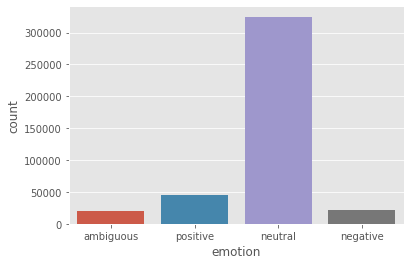

In [ ]:
# EDA and Preprocessing
# Class Distribution
sns.countplot(x = 'emotion', data=df)

In [ ]:
# Encode Output Class
class2idx = {
    'ambiguous':0,
    'negative':1,
    'neutral':2,
    'positive':3,
}

idx2class = {v: k for k, v in class2idx.items()}

df['emotion'].replace(class2idx, inplace=True)

In [ ]:
df.head()

,Unnamed: 0,frame,Nose_x,Nose_y,Nose_c,Neck_x,Neck_y,Neck_c,RShoulder_x,RShoulder_y,RShoulder_c,RElbow_x,RElbow_y,RElbow_c,RWrist_x,RWrist_y,RWrist_c,LShoulder_x,LShoulder_y,LShoulder_c,LElbow_x,LElbow_y,LElbow_c,LWrist_x,LWrist_y,LWrist_c,MidHip_x,MidHip_y,MidHip_c,RHip_x,RHip_y,RHip_c,RKnee_x,RKnee_y,RKnee_c,RAnkle_x,RAnkle_y,RAnkle_c,LHip_x,LHip_y,...,hr_point8_c,hr_point9_x,hr_point9_y,hr_point9_c,hr_point10_x,hr_point10_y,hr_point10_c,hr_point11_x,hr_point11_y,hr_point11_c,hr_point12_x,hr_point12_y,hr_point12_c,hr_point13_x,hr_point13_y,hr_point13_c,hr_point14_x,hr_point14_y,hr_point14_c,hr_point15_x,hr_point15_y,hr_point15_c,hr_point16_x,hr_point16_y,hr_point16_c,hr_point17_x,hr_point17_y,hr_point17_c,hr_point18_x,hr_point18_y,hr_point18_c,hr_point19_x,hr_point19_y,hr_point19_c,hr_point20_x,hr_point20_y,hr_point20_c,filename,emotion,videoname
0,0,1,562.779,102.411,0.907640,543.195,165.124,0.867135,492.306,165.034,0.827632,462.811,241.515,0.830692,480.476,257.061,0.805224,596.092,167.062,0.781668,611.726,264.998,0.723928,635.317,349.198,0.843380,551.012,323.804,0.637305,517.691,323.798,0.615599,525.578,464.856,0.750513,539.312,586.325,0.579356,584.318,323.762,...,0.113992,487.808,270.611,0.055322,494.123,273.919,0.069360,492.319,274.220,0.206929,490.214,272.716,0.285343,487.508,273.919,0.067824,499.235,270.310,0.244309,496.529,265.800,0.312649,495.326,259.786,0.151584,498.935,261.289,0.085853,502.242,263.394,0.251915,501.942,261.590,0.403513,501.040,255.876,0.522673,output_video6.csv,0,video01
1,1,2,560.860,102.402,0.910264,543.156,165.150,0.871095,492.276,165.048,0.836653,464.786,241.466,0.811072,482.415,257.075,0.810412,596.102,168.983,0.762419,611.733,263.029,0.725409,635.279,349.210,0.842287,547.087,323.752,0.657947,513.810,321.857,0.651405,523.634,466.768,0.770017,533.372,590.210,0.713921,580.397,321.862,...,0.038476,487.041,269.972,0.047497,489.723,279.505,0.048049,492.106,280.101,0.046241,493.596,275.632,0.030804,492.106,269.674,0.043908,498.958,268.184,0.030303,498.958,264.609,0.061021,498.660,258.651,0.044613,502.236,260.140,0.031777,504.023,261.332,0.046090,503.427,259.842,0.087379,501.640,256.267,0.135717,output_video6.csv,0,video01
2,2,3,560.798,102.359,0.923396,543.189,165.121,0.867678,492.280,164.998,0.836347,466.792,239.520,0.777852,484.372,257.105,0.800243,598.028,168.958,0.767903,611.772,261.073,0.747598,635.346,349.223,0.843892,549.014,321.848,0.650375,515.747,321.816,0.635799,519.620,462.940,0.716908,523.635,588.181,0.773207,582.329,321.813,...,0.197915,486.417,268.686,0.096429,492.773,274.754,0.082681,493.351,274.176,0.175678,491.617,275.331,0.133321,493.640,268.686,0.112211,499.418,270.420,0.254068,498.263,266.086,0.256436,496.240,258.862,0.279942,498.552,263.774,0.130395,502.886,264.063,0.261110,502.886,262.041,0.462578,502.597,256.840,0.604694,output_video6.csv,0,video01
3,3,4,558.914,102.321,0.930722,543.200,165.129,0.861878,492.282,163.164,0.839200,468.764,237.565,0.741477,480.519,257.102,0.796018,598.057,170.924,0.754375,613.656,266.908,0.731420,635.305,349.249,0.857972,543.250,325.707,0.655716,511.808,323.748,0.651776,511.861,464.780,0.754202,509.957,586.229,0.794806,578.438,325.699,...,0.221748,484.112,272.996,0.109295,480.963,283.587,0.103376,488.978,282.728,0.154196,489.837,278.435,0.166580,492.127,271.278,0.080522,496.993,272.710,0.126028,496.134,270.992,0.242762,494.703,262.118,0.215349,496.707,266.412,0.107075,501.859,266.126,0.230416,501.573,264.695,0.405128,500.714,259.828,0.508672,output_video6.csv,0,video01
4,4,5,558.904,100.481,0.932843,543.180,165.068,0.883817,492.251,163.128,0.860069,474.616,233.633,0.773151,480.515,257.167,0.812225,598.000,167.063,0.774960,611.772,264.970,0.755612,635.308,349.258,0.859445,541.320,323.730,0.680963,509.872,321.785,0.671638,509.816,462.805,0.792770,505.941,588.251,0.733877,576.452,323.727,...,0.154617,489.660,255.335,0.090149,487.794,264.133,0.098594,484.061,277.464,0.083608,486.994,279.597,0.079787,494.192,259.334,0.097416,491.793,265.466,0.312353,49

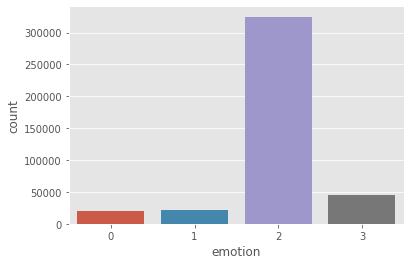

In [ ]:
# EDA and Preprocessing
# Class Distribution
sns.countplot(x = 'emotion', data=df)

In [ ]:
# Renaming a column
newcolumns = list(df.columns)
newcolumns[-1], newcolumns[-2] = newcolumns[-2], newcolumns[-1]
print (newcolumns)

['Unnamed: 0', 'frame', 'Nose_x', 'Nose_y', 'Nose_c', 'Neck_x', 'Neck_y', 'Neck_c', 'RShoulder_x', 'RShoulder_y', 'RShoulder_c', 'RElbow_x', 'RElbow_y', 'RElbow_c', 'RWrist_x', 'RWrist_y', 'RWrist_c', 'LShoulder_x', 'LShoulder_y', 'LShoulder_c', 'LElbow_x', 'LElbow_y', 'LElbow_c', 'LWrist_x', 'LWrist_y', 'LWrist_c', 'MidHip_x', 'MidHip_y', 'MidHip_c', 'RHip_x', 'RHip_y', 'RHip_c', 'RKnee_x', 'RKnee_y', 'RKnee_c', 'RAnkle_x', 'RAnkle_y', 'RAnkle_c', 'LHip_x', 'LHip_y', 'LHip_c', 'LKnee_x', 'LKnee_y', 'LKnee_c', 'LAnkle_x', 'LAnkle_y', 'LAnkle_c', 'REye_x', 'REye_y', 'REye_c', 'LEye_x', 'LEye_y', 'LEye_c', 'REar_x', 'REar_y', 'REar_c', 'LEar_x', 'LEar_y', 'LEar_c', 'LBigToe_x', 'LBigToe_y', 'LBigToe_c', 'LSmallToe_x', 'LSmallToe_y', 'LSmallToe_c', 'LHeel_x', 'LHeel_y', 'LHeel_c', 'RBigToe_x', 'RBigToe_y', 'RBigToe_c', 'RSmallToe_x', 'RSmallToe_y', 'RSmallToe_c', 'RHeel_x', 'RHeel_y', 'RHeel_c', 'face_point0_x', 'face_point0_y', 'face_point0_c', 'face_point1_x', 'face_point1_y', 'face_poi

In [ ]:
df = df.reindex(columns=newcolumns)
df.head()

,Unnamed: 0,frame,Nose_x,Nose_y,Nose_c,Neck_x,Neck_y,Neck_c,RShoulder_x,RShoulder_y,RShoulder_c,RElbow_x,RElbow_y,RElbow_c,RWrist_x,RWrist_y,RWrist_c,LShoulder_x,LShoulder_y,LShoulder_c,LElbow_x,LElbow_y,LElbow_c,LWrist_x,LWrist_y,LWrist_c,MidHip_x,MidHip_y,MidHip_c,RHip_x,RHip_y,RHip_c,RKnee_x,RKnee_y,RKnee_c,RAnkle_x,RAnkle_y,RAnkle_c,LHip_x,LHip_y,...,hr_point8_c,hr_point9_x,hr_point9_y,hr_point9_c,hr_point10_x,hr_point10_y,hr_point10_c,hr_point11_x,hr_point11_y,hr_point11_c,hr_point12_x,hr_point12_y,hr_point12_c,hr_point13_x,hr_point13_y,hr_point13_c,hr_point14_x,hr_point14_y,hr_point14_c,hr_point15_x,hr_point15_y,hr_point15_c,hr_point16_x,hr_point16_y,hr_point16_c,hr_point17_x,hr_point17_y,hr_point17_c,hr_point18_x,hr_point18_y,hr_point18_c,hr_point19_x,hr_point19_y,hr_point19_c,hr_point20_x,hr_point20_y,hr_point20_c,filename,videoname,emotion
0,0,1,562.779,102.411,0.907640,543.195,165.124,0.867135,492.306,165.034,0.827632,462.811,241.515,0.830692,480.476,257.061,0.805224,596.092,167.062,0.781668,611.726,264.998,0.723928,635.317,349.198,0.843380,551.012,323.804,0.637305,517.691,323.798,0.615599,525.578,464.856,0.750513,539.312,586.325,0.579356,584.318,323.762,...,0.113992,487.808,270.611,0.055322,494.123,273.919,0.069360,492.319,274.220,0.206929,490.214,272.716,0.285343,487.508,273.919,0.067824,499.235,270.310,0.244309,496.529,265.800,0.312649,495.326,259.786,0.151584,498.935,261.289,0.085853,502.242,263.394,0.251915,501.942,261.590,0.403513,501.040,255.876,0.522673,output_video6.csv,video01,0
1,1,2,560.860,102.402,0.910264,543.156,165.150,0.871095,492.276,165.048,0.836653,464.786,241.466,0.811072,482.415,257.075,0.810412,596.102,168.983,0.762419,611.733,263.029,0.725409,635.279,349.210,0.842287,547.087,323.752,0.657947,513.810,321.857,0.651405,523.634,466.768,0.770017,533.372,590.210,0.713921,580.397,321.862,...,0.038476,487.041,269.972,0.047497,489.723,279.505,0.048049,492.106,280.101,0.046241,493.596,275.632,0.030804,492.106,269.674,0.043908,498.958,268.184,0.030303,498.958,264.609,0.061021,498.660,258.651,0.044613,502.236,260.140,0.031777,504.023,261.332,0.046090,503.427,259.842,0.087379,501.640,256.267,0.135717,output_video6.csv,video01,0
2,2,3,560.798,102.359,0.923396,543.189,165.121,0.867678,492.280,164.998,0.836347,466.792,239.520,0.777852,484.372,257.105,0.800243,598.028,168.958,0.767903,611.772,261.073,0.747598,635.346,349.223,0.843892,549.014,321.848,0.650375,515.747,321.816,0.635799,519.620,462.940,0.716908,523.635,588.181,0.773207,582.329,321.813,...,0.197915,486.417,268.686,0.096429,492.773,274.754,0.082681,493.351,274.176,0.175678,491.617,275.331,0.133321,493.640,268.686,0.112211,499.418,270.420,0.254068,498.263,266.086,0.256436,496.240,258.862,0.279942,498.552,263.774,0.130395,502.886,264.063,0.261110,502.886,262.041,0.462578,502.597,256.840,0.604694,output_video6.csv,video01,0
3,3,4,558.914,102.321,0.930722,543.200,165.129,0.861878,492.282,163.164,0.839200,468.764,237.565,0.741477,480.519,257.102,0.796018,598.057,170.924,0.754375,613.656,266.908,0.731420,635.305,349.249,0.857972,543.250,325.707,0.655716,511.808,323.748,0.651776,511.861,464.780,0.754202,509.957,586.229,0.794806,578.438,325.699,...,0.221748,484.112,272.996,0.109295,480.963,283.587,0.103376,488.978,282.728,0.154196,489.837,278.435,0.166580,492.127,271.278,0.080522,496.993,272.710,0.126028,496.134,270.992,0.242762,494.703,262.118,0.215349,496.707,266.412,0.107075,501.859,266.126,0.230416,501.573,264.695,0.405128,500.714,259.828,0.508672,output_video6.csv,video01,0
4,4,5,558.904,100.481,0.932843,543.180,165.068,0.883817,492.251,163.128,0.860069,474.616,233.633,0.773151,480.515,257.167,0.812225,598.000,167.063,0.774960,611.772,264.970,0.755612,635.308,349.258,0.859445,541.320,323.730,0.680963,509.872,321.785,0.671638,509.816,462.805,0.792770,505.941,588.251,0.733877,576.452,323.727,...,0.154617,489.660,255.335,0.090149,487.794,264.133,0.098594,484.061,277.464,0.083608,486.994,279.597,0.079787,494.192,259.334,0.097416,491.793,265.466,0.312353,49

In [ ]:
df = df.drop(['Unnamed: 0'], axis=1)
df.head()

,frame,Nose_x,Nose_y,Nose_c,Neck_x,Neck_y,Neck_c,RShoulder_x,RShoulder_y,RShoulder_c,RElbow_x,RElbow_y,RElbow_c,RWrist_x,RWrist_y,RWrist_c,LShoulder_x,LShoulder_y,LShoulder_c,LElbow_x,LElbow_y,LElbow_c,LWrist_x,LWrist_y,LWrist_c,MidHip_x,MidHip_y,MidHip_c,RHip_x,RHip_y,RHip_c,RKnee_x,RKnee_y,RKnee_c,RAnkle_x,RAnkle_y,RAnkle_c,LHip_x,LHip_y,LHip_c,...,hr_point8_c,hr_point9_x,hr_point9_y,hr_point9_c,hr_point10_x,hr_point10_y,hr_point10_c,hr_point11_x,hr_point11_y,hr_point11_c,hr_point12_x,hr_point12_y,hr_point12_c,hr_point13_x,hr_point13_y,hr_point13_c,hr_point14_x,hr_point14_y,hr_point14_c,hr_point15_x,hr_point15_y,hr_point15_c,hr_point16_x,hr_point16_y,hr_point16_c,hr_point17_x,hr_point17_y,hr_point17_c,hr_point18_x,hr_point18_y,hr_point18_c,hr_point19_x,hr_point19_y,hr_point19_c,hr_point20_x,hr_point20_y,hr_point20_c,filename,videoname,emotion
0,1,562.779,102.411,0.907640,543.195,165.124,0.867135,492.306,165.034,0.827632,462.811,241.515,0.830692,480.476,257.061,0.805224,596.092,167.062,0.781668,611.726,264.998,0.723928,635.317,349.198,0.843380,551.012,323.804,0.637305,517.691,323.798,0.615599,525.578,464.856,0.750513,539.312,586.325,0.579356,584.318,323.762,0.658486,...,0.113992,487.808,270.611,0.055322,494.123,273.919,0.069360,492.319,274.220,0.206929,490.214,272.716,0.285343,487.508,273.919,0.067824,499.235,270.310,0.244309,496.529,265.800,0.312649,495.326,259.786,0.151584,498.935,261.289,0.085853,502.242,263.394,0.251915,501.942,261.590,0.403513,501.040,255.876,0.522673,output_video6.csv,video01,0
1,2,560.860,102.402,0.910264,543.156,165.150,0.871095,492.276,165.048,0.836653,464.786,241.466,0.811072,482.415,257.075,0.810412,596.102,168.983,0.762419,611.733,263.029,0.725409,635.279,349.210,0.842287,547.087,323.752,0.657947,513.810,321.857,0.651405,523.634,466.768,0.770017,533.372,590.210,0.713921,580.397,321.862,0.661597,...,0.038476,487.041,269.972,0.047497,489.723,279.505,0.048049,492.106,280.101,0.046241,493.596,275.632,0.030804,492.106,269.674,0.043908,498.958,268.184,0.030303,498.958,264.609,0.061021,498.660,258.651,0.044613,502.236,260.140,0.031777,504.023,261.332,0.046090,503.427,259.842,0.087379,501.640,256.267,0.135717,output_video6.csv,video01,0
2,3,560.798,102.359,0.923396,543.189,165.121,0.867678,492.280,164.998,0.836347,466.792,239.520,0.777852,484.372,257.105,0.800243,598.028,168.958,0.767903,611.772,261.073,0.747598,635.346,349.223,0.843892,549.014,321.848,0.650375,515.747,321.816,0.635799,519.620,462.940,0.716908,523.635,588.181,0.773207,582.329,321.813,0.666361,...,0.197915,486.417,268.686,0.096429,492.773,274.754,0.082681,493.351,274.176,0.175678,491.617,275.331,0.133321,493.640,268.686,0.112211,499.418,270.420,0.254068,498.263,266.086,0.256436,496.240,258.862,0.279942,498.552,263.774,0.130395,502.886,264.063,0.261110,502.886,262.041,0.462578,502.597,256.840,0.604694,output_video6.csv,video01,0
3,4,558.914,102.321,0.930722,543.200,165.129,0.861878,492.282,163.164,0.839200,468.764,237.565,0.741477,480.519,257.102,0.796018,598.057,170.924,0.754375,613.656,266.908,0.731420,635.305,349.249,0.857972,543.250,325.707,0.655716,511.808,323.748,0.651776,511.861,464.780,0.754202,509.957,586.229,0.794806,578.438,325.699,0.655562,...,0.221748,484.112,272.996,0.109295,480.963,283.587,0.103376,488.978,282.728,0.154196,489.837,278.435,0.166580,492.127,271.278,0.080522,496.993,272.710,0.126028,496.134,270.992,0.242762,494.703,262.118,0.215349,496.707,266.412,0.107075,501.859,266.126,0.230416,501.573,264.695,0.405128,500.714,259.828,0.508672,output_video6.csv,video01,0
4,5,558.904,100.481,0.932843,543.180,165.068,0.883817,492.251,163.128,0.860069,474.616,233.633,0.773151,480.515,257.167,0.812225,598.000,167.063,0.774960,611.772,264.970,0.755612,635.308,349.258,0.859445,541.320,323.730,0.680963,509.872,321.785,0.671638,509.816,462.805,0.792770,505.941,588.251,0.733877,576.452,323.727,0.659965,...,0.154617,489.660,255.335,0.090149,487.794,264.133,0.098594,484.061,277.464,0.083608,486.994,279.597,0.079787,494.192,259.334,0.097

In [ ]:
# Rewrite Unnamed: 0 to frame to start frame at 0
df["frame"]=df["frame"]-1
df.head()

,frame,Nose_x,Nose_y,Nose_c,Neck_x,Neck_y,Neck_c,RShoulder_x,RShoulder_y,RShoulder_c,RElbow_x,RElbow_y,RElbow_c,RWrist_x,RWrist_y,RWrist_c,LShoulder_x,LShoulder_y,LShoulder_c,LElbow_x,LElbow_y,LElbow_c,LWrist_x,LWrist_y,LWrist_c,MidHip_x,MidHip_y,MidHip_c,RHip_x,RHip_y,RHip_c,RKnee_x,RKnee_y,RKnee_c,RAnkle_x,RAnkle_y,RAnkle_c,LHip_x,LHip_y,LHip_c,...,hr_point8_c,hr_point9_x,hr_point9_y,hr_point9_c,hr_point10_x,hr_point10_y,hr_point10_c,hr_point11_x,hr_point11_y,hr_point11_c,hr_point12_x,hr_point12_y,hr_point12_c,hr_point13_x,hr_point13_y,hr_point13_c,hr_point14_x,hr_point14_y,hr_point14_c,hr_point15_x,hr_point15_y,hr_point15_c,hr_point16_x,hr_point16_y,hr_point16_c,hr_point17_x,hr_point17_y,hr_point17_c,hr_point18_x,hr_point18_y,hr_point18_c,hr_point19_x,hr_point19_y,hr_point19_c,hr_point20_x,hr_point20_y,hr_point20_c,filename,videoname,emotion
0,0,562.779,102.411,0.907640,543.195,165.124,0.867135,492.306,165.034,0.827632,462.811,241.515,0.830692,480.476,257.061,0.805224,596.092,167.062,0.781668,611.726,264.998,0.723928,635.317,349.198,0.843380,551.012,323.804,0.637305,517.691,323.798,0.615599,525.578,464.856,0.750513,539.312,586.325,0.579356,584.318,323.762,0.658486,...,0.113992,487.808,270.611,0.055322,494.123,273.919,0.069360,492.319,274.220,0.206929,490.214,272.716,0.285343,487.508,273.919,0.067824,499.235,270.310,0.244309,496.529,265.800,0.312649,495.326,259.786,0.151584,498.935,261.289,0.085853,502.242,263.394,0.251915,501.942,261.590,0.403513,501.040,255.876,0.522673,output_video6.csv,video01,0
1,1,560.860,102.402,0.910264,543.156,165.150,0.871095,492.276,165.048,0.836653,464.786,241.466,0.811072,482.415,257.075,0.810412,596.102,168.983,0.762419,611.733,263.029,0.725409,635.279,349.210,0.842287,547.087,323.752,0.657947,513.810,321.857,0.651405,523.634,466.768,0.770017,533.372,590.210,0.713921,580.397,321.862,0.661597,...,0.038476,487.041,269.972,0.047497,489.723,279.505,0.048049,492.106,280.101,0.046241,493.596,275.632,0.030804,492.106,269.674,0.043908,498.958,268.184,0.030303,498.958,264.609,0.061021,498.660,258.651,0.044613,502.236,260.140,0.031777,504.023,261.332,0.046090,503.427,259.842,0.087379,501.640,256.267,0.135717,output_video6.csv,video01,0
2,2,560.798,102.359,0.923396,543.189,165.121,0.867678,492.280,164.998,0.836347,466.792,239.520,0.777852,484.372,257.105,0.800243,598.028,168.958,0.767903,611.772,261.073,0.747598,635.346,349.223,0.843892,549.014,321.848,0.650375,515.747,321.816,0.635799,519.620,462.940,0.716908,523.635,588.181,0.773207,582.329,321.813,0.666361,...,0.197915,486.417,268.686,0.096429,492.773,274.754,0.082681,493.351,274.176,0.175678,491.617,275.331,0.133321,493.640,268.686,0.112211,499.418,270.420,0.254068,498.263,266.086,0.256436,496.240,258.862,0.279942,498.552,263.774,0.130395,502.886,264.063,0.261110,502.886,262.041,0.462578,502.597,256.840,0.604694,output_video6.csv,video01,0
3,3,558.914,102.321,0.930722,543.200,165.129,0.861878,492.282,163.164,0.839200,468.764,237.565,0.741477,480.519,257.102,0.796018,598.057,170.924,0.754375,613.656,266.908,0.731420,635.305,349.249,0.857972,543.250,325.707,0.655716,511.808,323.748,0.651776,511.861,464.780,0.754202,509.957,586.229,0.794806,578.438,325.699,0.655562,...,0.221748,484.112,272.996,0.109295,480.963,283.587,0.103376,488.978,282.728,0.154196,489.837,278.435,0.166580,492.127,271.278,0.080522,496.993,272.710,0.126028,496.134,270.992,0.242762,494.703,262.118,0.215349,496.707,266.412,0.107075,501.859,266.126,0.230416,501.573,264.695,0.405128,500.714,259.828,0.508672,output_video6.csv,video01,0
4,4,558.904,100.481,0.932843,543.180,165.068,0.883817,492.251,163.128,0.860069,474.616,233.633,0.773151,480.515,257.167,0.812225,598.000,167.063,0.774960,611.772,264.970,0.755612,635.308,349.258,0.859445,541.320,323.730,0.680963,509.872,321.785,0.671638,509.816,462.805,0.792770,505.941,588.251,0.733877,576.452,323.727,0.659965,...,0.154617,489.660,255.335,0.090149,487.794,264.133,0.098594,484.061,277.464,0.083608,486.994,279.597,0.079787,494.192,259.334,0.097

In [ ]:
df.tail()

,frame,Nose_x,Nose_y,Nose_c,Neck_x,Neck_y,Neck_c,RShoulder_x,RShoulder_y,RShoulder_c,RElbow_x,RElbow_y,RElbow_c,RWrist_x,RWrist_y,RWrist_c,LShoulder_x,LShoulder_y,LShoulder_c,LElbow_x,LElbow_y,LElbow_c,LWrist_x,LWrist_y,LWrist_c,MidHip_x,MidHip_y,MidHip_c,RHip_x,RHip_y,RHip_c,RKnee_x,RKnee_y,RKnee_c,RAnkle_x,RAnkle_y,RAnkle_c,LHip_x,LHip_y,LHip_c,...,hr_point8_c,hr_point9_x,hr_point9_y,hr_point9_c,hr_point10_x,hr_point10_y,hr_point10_c,hr_point11_x,hr_point11_y,hr_point11_c,hr_point12_x,hr_point12_y,hr_point12_c,hr_point13_x,hr_point13_y,hr_point13_c,hr_point14_x,hr_point14_y,hr_point14_c,hr_point15_x,hr_point15_y,hr_point15_c,hr_point16_x,hr_point16_y,hr_point16_c,hr_point17_x,hr_point17_y,hr_point17_c,hr_point18_x,hr_point18_y,hr_point18_c,hr_point19_x,hr_point19_y,hr_point19_c,hr_point20_x,hr_point20_y,hr_point20_c,filename,videoname,emotion
413001,62,464.863,455.039,0.409733,458.947,476.589,0.114485,439.345,476.596,0.076545,0.000,0.000,0.000000,0.0,0.0,0.0,480.474,478.461,0.139535,0.000,0.000,0.000000,0.0,0.0,0.0,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,output_video166.csv,video14,2
413002,67,592.139,445.240,0.322106,570.671,464.844,0.235552,543.153,462.884,0.190606,0.000,0.000,0.000000,0.0,0.0,0.0,598.033,470.688,0.167872,0.000,0.000,0.000000,0.0,0.0,0.0,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,output_video166.csv,video14,2
413003,88,435.441,423.705,0.271856,443.288,435.461,0.318059,431.524,437.362,0.278656,431.536,460.911,0.111483,0.0,0.0,0.0,447.282,435.474,0.327534,458.919,458.907,0.163403,0.0,0.0,0.0,445.177,476.590,0.245142,439.337,476.616,0.219562,439.368,494.250,0.055416,0.000,0.000,0.000000,447.220,476.597,0.243612,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,output_video166.csv,video14,2
413004,113,0.000,0.000,0.000000,368.857,272.825,0.167703,364.913,270.883,0.150315,353.169,296.341,0.091130,0.0,0.0,0.0,378.602,270.860,0.132303,0.000,0.000,0.000000,0.0,0.0,0.0,368.827,323.767,0.210686,364.911,321.838,0.224921,353.125,366.882,0.201870,351.128,404.079,0.264539,374.694,325.708,0.198102,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,output_video166.csv,video14,2
413005,194,554.856,384.428,0.387378,553.000,433.503,0.227456,511.858,429.567,0.166993,0.000,0.000,0.000000,0.0,0.0,0.0,596.067,439.348,0.134611,0.000,0.000,0.000000,0.0,0.0,0.0,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,output_video166.csv,video14,2


In [ ]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]
print (X.head())
print (y.head())

   frame   Nose_x   Nose_y  ...  hr_point20_c           filename  videoname
0      0  562.779  102.411  ...      0.522673  output_video6.csv    video01
1      1  560.860  102.402  ...      0.135717  output_video6.csv    video01
2      2  560.798  102.359  ...      0.604694  output_video6.csv    video01
3      3  558.914  102.321  ...      0.508672  output_video6.csv    video01
4      4  558.904  100.481  ...      0.481841  output_video6.csv    video01

[5 rows x 414 columns]
0    0
1    0
2    0
3    0
4    0
Name: emotion, dtype: int64


In [ ]:
# Prepare Train — Validation — Test dataset
# Split into (train + val) and test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Split train into train + val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=21)

In [ ]:
# Pre-processing :remove 'frame', 'filename' and 'videoname'
X_trainval = X_trainval.drop(['frame', 'filename', 'videoname'], axis=1)
X_test_temp = X_test.copy()
X_test = X_test.drop(['frame', 'filename', 'videoname'], axis=1)
X_train = X_train.drop(['frame', 'filename', 'videoname'], axis=1)
X_val = X_val.drop(['frame', 'filename', 'videoname'], axis=1)
X_train.head()

,Nose_x,Nose_y,Nose_c,Neck_x,Neck_y,Neck_c,RShoulder_x,RShoulder_y,RShoulder_c,RElbow_x,RElbow_y,RElbow_c,RWrist_x,RWrist_y,RWrist_c,LShoulder_x,LShoulder_y,LShoulder_c,LElbow_x,LElbow_y,LElbow_c,LWrist_x,LWrist_y,LWrist_c,MidHip_x,MidHip_y,MidHip_c,RHip_x,RHip_y,RHip_c,RKnee_x,RKnee_y,RKnee_c,RAnkle_x,RAnkle_y,RAnkle_c,LHip_x,LHip_y,LHip_c,LKnee_x,...,hr_point7_c,hr_point8_x,hr_point8_y,hr_point8_c,hr_point9_x,hr_point9_y,hr_point9_c,hr_point10_x,hr_point10_y,hr_point10_c,hr_point11_x,hr_point11_y,hr_point11_c,hr_point12_x,hr_point12_y,hr_point12_c,hr_point13_x,hr_point13_y,hr_point13_c,hr_point14_x,hr_point14_y,hr_point14_c,hr_point15_x,hr_point15_y,hr_point15_c,hr_point16_x,hr_point16_y,hr_point16_c,hr_point17_x,hr_point17_y,hr_point17_c,hr_point18_x,hr_point18_y,hr_point18_c,hr_point19_x,hr_point19_y,hr_point19_c,hr_point20_x,hr_point20_y,hr_point20_c
262893,588.336,176.807,0.869521,570.497,304.106,0.804445,462.793,304.201,0.719930,431.511,480.461,0.639829,517.680,441.260,0.698126,680.292,296.342,0.659719,713.659,480.499,0.452748,617.563,431.600,0.792258,556.868,582.363,0.299760,494.189,584.320,0.254430,0.0,0.0,0.0,0.0,0.0,0.0,619.635,588.228,0.241529,0.0,...,0.155158,560.564,365.279,0.115606,536.922,384.323,0.033943,540.862,388.264,0.127138,557.280,371.189,0.187334,568.444,363.309,0.207748,531.012,412.562,0.037278,540.862,391.547,0.142402,553.997,376.443,0.174383,568.444,365.935,0.250252,532.325,413.876,0.049469,543.489,388.920,0.087452,553.997,379.070,0.111716,564.504,373.159,0.177735
26313,337.984,146.244,0.776270,372.214,303.749,0.295104,214.727,337.988,0.323841,0.000,0.000,0.000000,0.000,0.000,0.000000,528.733,312.539,0.398410,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000000,0.0,...,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000
251437,562.774,192.508,0.840280,539.258,268.892,0.756563,441.331,274.732,0.672450,429.516,476.595,0.534757,462.937,415.784,0.737456,637.241,257.077,0.660939,680.303,423.667,0.459844,603.904,396.194,0.762398,547.107,535.353,0.210095,484.408,537.288,0.184373,0.0,0.0,0.0,0.0,0.0,0.0,619.553,533.383,0.204247,0.0,...,0.805982,495.478,356.401,0.726400,462.839,386.073,0.682062,476.191,378.655,0.500381,491.027,374.204,0.673513,500.670,374.204,0.790343,465.064,403.876,0.703633,478.416,398.684,0.509575,489.543,394.233,0.720135,498.445,391.266,0.832810,474.707,418.712,0.536836,488.802,421.679,0.615284,499.929,417.229,0.810075,508.830,411.294,0.751739
64340,652.922,194.476,0.837640,607.811,319.864,0.750223,474.634,321.795,0.630521,421.692,502.038,0.415613,511.811,560.787,0.485606,741.027,317.879,0.656025,805.697,490.269,0.561691,760.584,550.997,0.627011,617.579,647.018,0.187406,525.571,643.087,0.144771,0.0,0.0,0.0,0.0,0.0,0.0,705.776,662.683,0.155926,0.0,...,0.559433,615.979,566.391,0.348263,556.023,584.998,0.488225,592.548,587.755,0.473913,604.263,578.107,0.269039,605.642,573.972,0.189442,558.090,592.579,0.401294,587.035,596.025,0.185978,600.129,589.133,0.214742,600.818,579.485,0.193767,560.847,601.538,0.336875,577.387,604.294,0.316140,589.102,604.984,0.242746,600.129,603.605,0.172729
259311,793.918,165.176,0.882510,746.956,294.375,0.647776,648.984,290.463,0.571280,617.582,447.206,0.237942,639.186,464.871,0.637605,846.820,298.258,0.503820,0.000,0.000,0.000000,0.000,0.000,0.000000,760.634,564.734,0.063660,694.047,572.550,0.083798,0.0,0.0,0.0,0.0,0.0,0.0,817.456,574.534,0.064735,0.0,...,0.058642,638.692,459.558,0.040548,641.624,458.386,0.046470,645.729,461.904,0.067501,638.692,475.979,0.050178,638.105,477.152,0.043923,641.624,472.460,0.038410,639.865,468.941,0.044971,638.692,469.528,0.039313,639.278,486.535,0.030137,688.539,447.830,0.043323,676.224,467.769,0.019956,683.261,458.386,0.022181,638.692

In [ ]:
# Normalize Input
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)
X_test_temp, y_test = np.array(X_test_temp), np.array(y_test)

In [ ]:
def get_class_distribution(obj):
    count_dict = {
        "ambiguous": 0,
        "negative": 0,
        "neutral": 0,
        "positive": 0,
    }
    
    for i in obj:
        if i == 0: 
            count_dict['ambiguous'] += 1
        elif i == 1: 
            count_dict['negative'] += 1
        elif i == 2: 
            count_dict['neutral'] += 1
        elif i == 3: 
            count_dict['positive'] += 1           
        else:
            print("Check classes.")
            
    return count_dict

Text(0.5, 1.0, 'Class Distribution in Test Set')

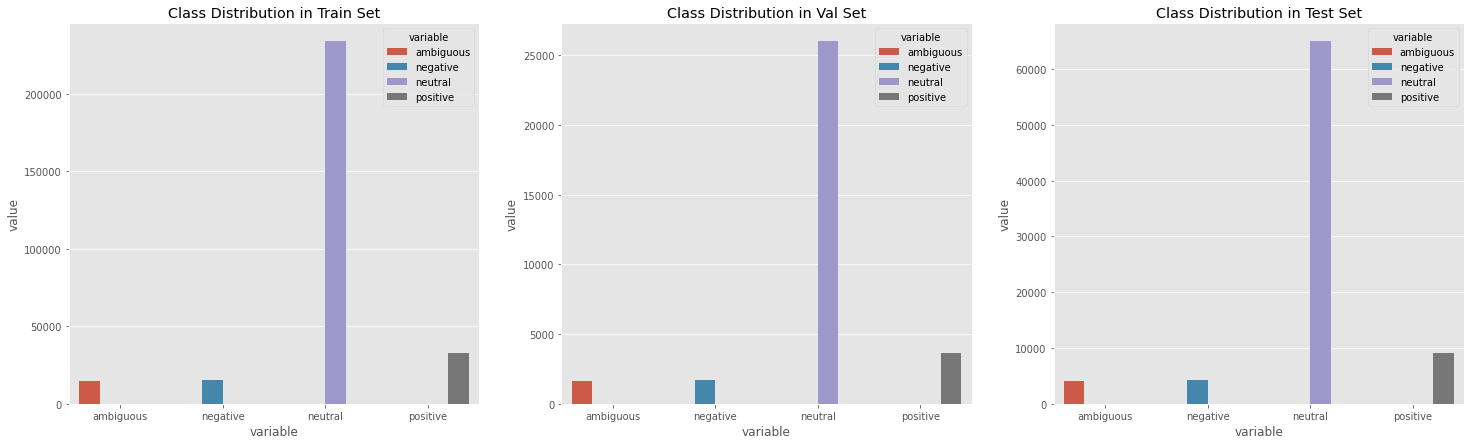

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')
# Validation
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')
# Test
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')

Text(0.5, 1.0, 'Class Distribution in Test Set')

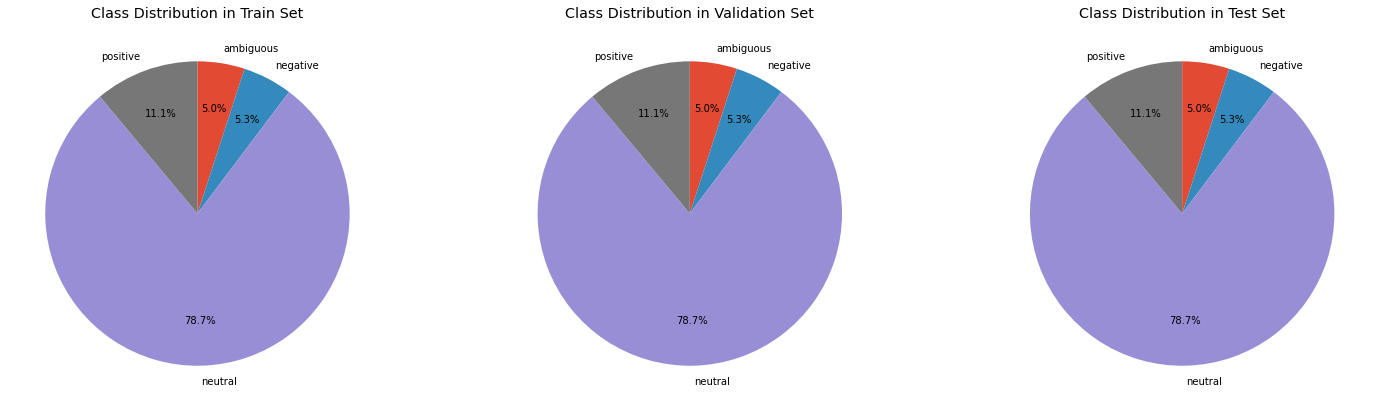

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
# Train
axes[0].pie((pd.DataFrame.from_dict([get_class_distribution(y_train)])).melt()["value"],
       labels=(pd.DataFrame.from_dict([get_class_distribution(y_train)])).melt()["variable"], counterclock=False, startangle=90,autopct='%1.1f%%', pctdistance=0.7)
axes[0].set_title("Class Distribution in Train Set")

# Validation
axes[1].pie((pd.DataFrame.from_dict([get_class_distribution(y_val)])).melt()["value"],
       labels=(pd.DataFrame.from_dict([get_class_distribution(y_val)])).melt()["variable"], counterclock=False, startangle=90,autopct='%1.1f%%', pctdistance=0.7)
axes[1].set_title("Class Distribution in Validation Set")
# Test
axes[2].pie((pd.DataFrame.from_dict([get_class_distribution(y_test)])).melt()["value"],
       labels=(pd.DataFrame.from_dict([get_class_distribution(y_test)])).melt()["variable"], counterclock=False, startangle=90,autopct='%1.1f%%', pctdistance=0.7)
axes[2].set_title("Class Distribution in Test Set")

In [ ]:
# Neural Network
# Custom Dataset
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

In [ ]:
# Model Parameters
EPOCHS = 300 # original 300
BATCH_SIZE = 32 # original 16
LEARNING_RATE = 0.001

NUM_FEATURES = len(X.columns) - 3
NUM_CLASSES = 4

In [ ]:
# Dataloader
train_loader = DataLoader(
    dataset = train_dataset,
    batch_size = BATCH_SIZE,
    shuffle = True
    #sampler = weighted_sampler
)

val_loader = DataLoader(dataset = val_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(dataset = test_dataset, batch_size=1, shuffle=False)

In [ ]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        self.fc1 = nn.Linear(num_feature, 400)  # All bonding layers
        self.fc2 = nn.Linear(400, 200)
        self.fc3 = nn.Linear(200, num_class)

        #self.batchnorm1 = nn.BatchNorm1d(200)

    def forward(self, x):# number of inputs
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        #x = self.batchnorm1(x)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.cuda()  # GPU
print(model)

MulticlassClassification(
  (fc1): Linear(in_features=411, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=4, bias=True)
)


In [ ]:
# Cross-entropy error function
loss_fnc = nn.CrossEntropyLoss()

# SGD
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

In [ ]:
# Loss log
record_loss_train = []
record_loss_test = []

# Learning
for e in tqdm(range(1, EPOCHS+1)):  # Epoch Learning

    model.train()  # Training mode
    loss_train = 0.0
    for j, (x, t) in enumerate(train_loader):  # Extract mini-batch (x, t)
        x, t = x.cuda(), t.cuda()  # GPU
        optimizer.zero_grad()

        y = model(x)
        loss = loss_fnc(y, t)

        loss.backward()
        optimizer.step()

        loss_train += loss.item()
        #pred = torch.argmax(y, dim=1)
        #acc_train += torch.mean(pred.eq(t).float())
        
    loss_train /= j+1
    record_loss_train.append(loss_train/len(train_loader))

    model.eval()  # validation
    loss_val = 0.0

    for j, (x, t) in enumerate(val_loader):  # Extract mini-batch (x, t)
        x, t = x.cuda(), t.cuda()
        y = model(x)
        loss = loss_fnc(y, t)
        loss_val += loss.item()
        #pred = torch.argmax(y, dim=1)
        #acc_val += torch.mean(pred.eq(t).float())
    

    loss_val /= j+1
    record_loss_test.append(loss_val/len(val_loader))

    if e%10 == 0:
        print("Epoch:", e, "Loss_Train:", loss_train, "Loss_Test:", loss_val)

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 10 Loss_Train: 0.7069945190705974 Loss_Test: 0.7053609415892169
Epoch: 20 Loss_Train: 0.6936940603879403 Loss_Test: 0.6923689621053543
Epoch: 30 Loss_Train: 0.679247127225937 Loss_Test: 0.6782683536665085
Epoch: 40 Loss_Train: 0.6647758151051893 Loss_Test: 0.665325067332357
Epoch: 50 Loss_Train: 0.6505350311717985 Loss_Test: 0.6517260683422478
Epoch: 60 Loss_Train: 0.6365831262467816 Loss_Test: 0.6431794336797184
Epoch: 70 Loss_Train: 0.6239676579991775 Loss_Test: 0.6338492456265254
Epoch: 80 Loss_Train: 0.6119447951310805 Loss_Test: 0.6148548163580769
Epoch: 90 Loss_Train: 0.6012588313414029 Loss_Test: 0.6066514898308634
Epoch: 100 Loss_Train: 0.5908948885000113 Loss_Test: 0.5991944232329018
Epoch: 110 Loss_Train: 0.5806258896522702 Loss_Test: 0.5990476149887035
Epoch: 120 Loss_Train: 0.5704146172583944 Loss_Test: 0.5862570747733642
Epoch: 130 Loss_Train: 0.5611647028212627 Loss_Test: 0.5722858683464567
Epoch: 140 Loss_Train: 0.5519826503647525 Loss_Test: 0.5681986947532164
Epo

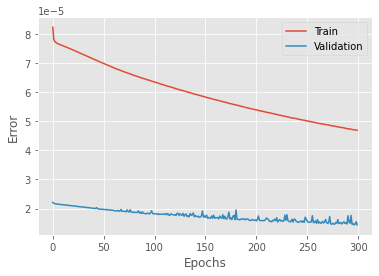

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(len(record_loss_train)), record_loss_train, label = "Train")
plt.plot(range(len(record_loss_test)), record_loss_test, label = "Validation")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

In [ ]:
correct = 0
total = 0

y_pred = []
y_true = []


columnlist = list(df.columns)[0:-1]+["emotion","label"]
print (columnlist)
correctdf = pd.DataFrame(columns=columnlist)
faildf = pd.DataFrame(columns=columnlist)
correctcount = 0
failcount = 0
for i, ((x, t),(x1)) in enumerate(zip(test_loader,X_test_temp)):
    #print (x[0,:])
    x, t = x.cuda(), t.cuda()  # GPU
    x = x.view(-1,NUM_FEATURES)
    y = model(x)

    #output = (torch.max(torch.exp(y), 1)[1]).data.cpu().numpy()
    output = (y.argmax(1)).data.cpu().numpy()
    y_pred.extend(output) # Save Prediction
    #print (output)
        
    labels = t.data.cpu().numpy()
    y_true.extend(labels) # Save Truth
    #print (labels)

    correct += (y.argmax(1) == t).sum().item()
    
    if y.argmax(1)==t and correctcount<1001:
      temp = [x1.reshape(1,414).tolist()[0]+[output[0],labels[0]]]
      correctdf = correctdf.append(pd.DataFrame(temp,columns=columnlist))
      correctcount +=1

    elif y.argmax(1)!=t and failcount<1001:
      temp = [x1.reshape(1,414).tolist()[0]+[output[0],labels[0]]]
      #print (temp)
      faildf = faildf.append(pd.DataFrame(temp,columns=columnlist))
      failcount +=1

    total += len(x)
    
print("Accuracy rate:", str(correct/total*100) + "%")

#print(correctdf.head())
#print(faildf.head())

['frame', 'Nose_x', 'Nose_y', 'Nose_c', 'Neck_x', 'Neck_y', 'Neck_c', 'RShoulder_x', 'RShoulder_y', 'RShoulder_c', 'RElbow_x', 'RElbow_y', 'RElbow_c', 'RWrist_x', 'RWrist_y', 'RWrist_c', 'LShoulder_x', 'LShoulder_y', 'LShoulder_c', 'LElbow_x', 'LElbow_y', 'LElbow_c', 'LWrist_x', 'LWrist_y', 'LWrist_c', 'MidHip_x', 'MidHip_y', 'MidHip_c', 'RHip_x', 'RHip_y', 'RHip_c', 'RKnee_x', 'RKnee_y', 'RKnee_c', 'RAnkle_x', 'RAnkle_y', 'RAnkle_c', 'LHip_x', 'LHip_y', 'LHip_c', 'LKnee_x', 'LKnee_y', 'LKnee_c', 'LAnkle_x', 'LAnkle_y', 'LAnkle_c', 'REye_x', 'REye_y', 'REye_c', 'LEye_x', 'LEye_y', 'LEye_c', 'REar_x', 'REar_y', 'REar_c', 'LEar_x', 'LEar_y', 'LEar_c', 'LBigToe_x', 'LBigToe_y', 'LBigToe_c', 'LSmallToe_x', 'LSmallToe_y', 'LSmallToe_c', 'LHeel_x', 'LHeel_y', 'LHeel_c', 'RBigToe_x', 'RBigToe_y', 'RBigToe_c', 'RSmallToe_x', 'RSmallToe_y', 'RSmallToe_c', 'RHeel_x', 'RHeel_y', 'RHeel_c', 'face_point0_x', 'face_point0_y', 'face_point0_c', 'face_point1_x', 'face_point1_y', 'face_point1_c', 'face_

In [ ]:
correctdf.to_csv("/content/drive/MyDrive/05_workspace/01_msc_project/data/output/14_predict_emotion_from_pose/group/model02(3NN_Epoch300)/correct_df.csv")
faildf.to_csv("/content/drive/MyDrive/05_workspace/01_msc_project/data/output/14_predict_emotion_from_pose/group/model02(3NN_Epoch300)/incorrect_df.csv")

[[ 1252    39  2665   178]
 [  100   945  3085   222]
 [  359   251 63403   964]
 [  140    93  6019  2887]]


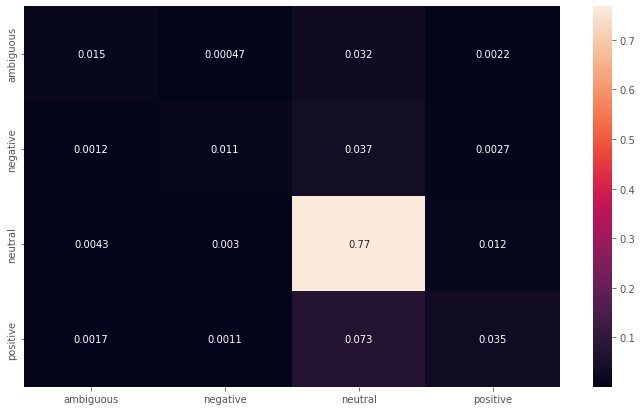

In [ ]:
import seaborn as sn
classes = ('ambiguous', 'negative', 'neutral', 'positive')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
print (cf_matrix)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) , index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/05_workspace/01_msc_project/data/output/14_predict_emotion_from_pose/group/model02(3NN_Epoch300)/pytorch_epoch300_model.pth")